### Objective: Which products will an Instacart consumer purchase next?
#### We'll apply some different models to observe their predictive performance. 

In [1]:
import pandas as pd
import numpy as np
pd.set_option('precision',4)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [2]:
# read in sample datasets
prior_orders_df = pd.read_csv('transformed/prior_order_features_sample.csv')
train_orders_df = pd.read_csv('transformed/train_order_features_sample.csv')

In [3]:
# evaluate performance using LR

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# assign features and targets from training data
X_prior = prior_orders_df[['user_prod_reorders','user_prod_reorder_rate','prod_reorder_rate','user_orders']]
y_prior = prior_orders_df['reordered']

# initialize validation data
X_train = train_orders_df[['user_prod_reorders','user_prod_reorder_rate','prod_reorder_rate','user_orders']]
y_train = train_orders_df['reordered']

lr = LogisticRegression()
lr.fit(X_prior,y_prior)

# Calculate precision and recall scores
accuracy = lr.score(X_train,y_train)
precision = float(precision_score(y_train, lr.predict(X_train)))
recall = float(recall_score(y_train, lr.predict(X_train)))

print("The accuracy score is {:.1f}%.".format(accuracy*100))

print("The precision is {:.1f}% and the recall is {:.1f}%.".format(precision * 100, recall * 100))

The accuracy score is 69.6%.
The precision is 100.0% and the recall is 49.2%.


In [4]:
# determine null accuracy
y_train.value_counts(normalize=True)

1    0.598
0    0.402
Name: reordered, dtype: float64

_It appears the LR model has very high precision and perfect recall, far exceeding the null accuracy baseline._

Text(0.5,0,u'False Positive Rate')

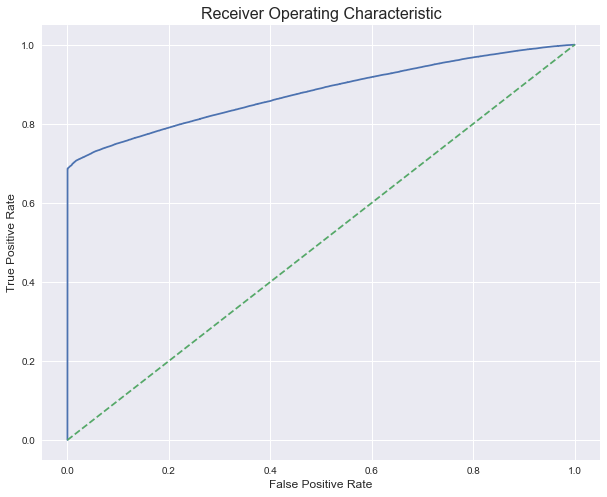

In [5]:
# Visualize precision and recall using ROC curve

from sklearn.metrics import roc_curve, roc_auc_score

y_prob = lr.predict_proba(X_train)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, y_prob)

plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic', fontsize=16)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls='--')
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)

In [6]:
# Calculate the area under the curve using AUROC score
# The estimated probability that a uniformly drawn random positive is ranked before a uniformly drawn random negative.
ras = roc_auc_score(y_train, y_prob)
print("The AUROC score is {:.1f}%.".format(ras*100))

The AUROC score is 87.8%.


In [7]:
# Let's take a look at how some other models perform

from sklearn import ensemble, neighbors
from sklearn.model_selection import cross_val_score

cls = ensemble.RandomForestClassifier(n_estimators=50) 
cls.fit(X_prior, y_prior)

print ('Random Forest: {:.1f}%.'.format( cross_val_score(cls, X_train, y_train, scoring='roc_auc', cv=5).mean() * 100 ))
    
cls = ensemble.GradientBoostingClassifier(n_estimators=50) 
cls.fit(X_prior, y_prior)

print ('GBDT: {:.1f}%.'.format( cross_val_score(cls, X_train, y_train, scoring='roc_auc', cv=5).mean() * 100 ))
    
cls = neighbors.KNeighborsClassifier(n_neighbors=5)
cls.fit(X_prior, y_prior)

print ('KNN: {:.1f}%.'.format( cross_val_score(cls, X_train, y_train, scoring='roc_auc', cv=5).mean() * 100 ))

Random Forest: 86.6%.
GBDT: 88.6%.
KNN: 86.3%.


Logistic:
	Brier: 0.181
	Precision: 1.000
	Recall: 0.526
	F1: 0.689

Naive Bayes:
	Brier: 0.316
	Precision: 0.995
	Recall: 0.315
	F1: 0.478

Naive Bayes + Isotonic:
	Brier: 0.184
	Precision: 0.965
	Recall: 0.560
	F1: 0.709

Naive Bayes + Sigmoid:
	Brier: 0.194
	Precision: 0.985
	Recall: 0.439
	F1: 0.607

Logistic:
	Brier: 0.181
	Precision: 1.000
	Recall: 0.526
	F1: 0.689

SVC:
	Brier: 0.501
	Precision: 0.665
	Recall: 0.934
	F1: 0.777

SVC + Isotonic:
	Brier: 0.160
	Precision: 0.994
	Recall: 0.636
	F1: 0.776

SVC + Sigmoid:
	Brier: 0.213
	Precision: 0.931
	Recall: 0.418
	F1: 0.577



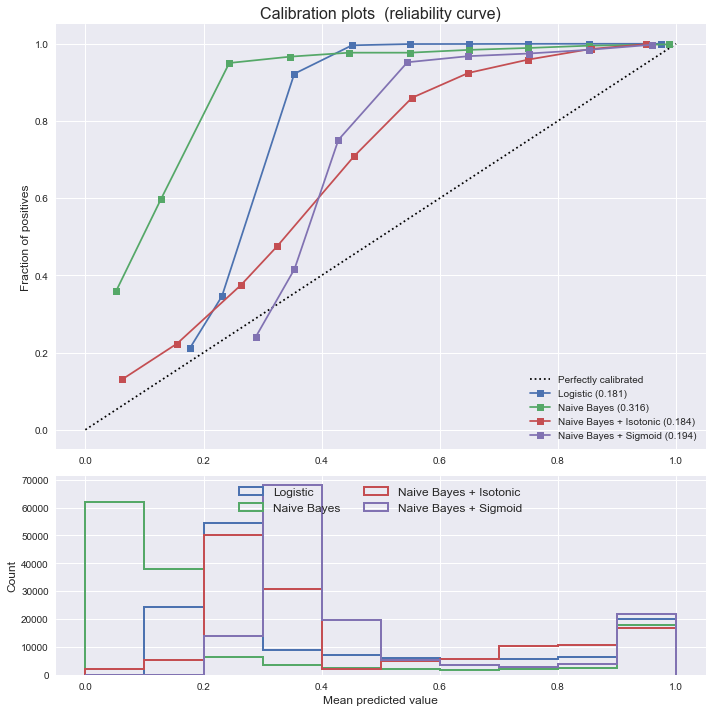

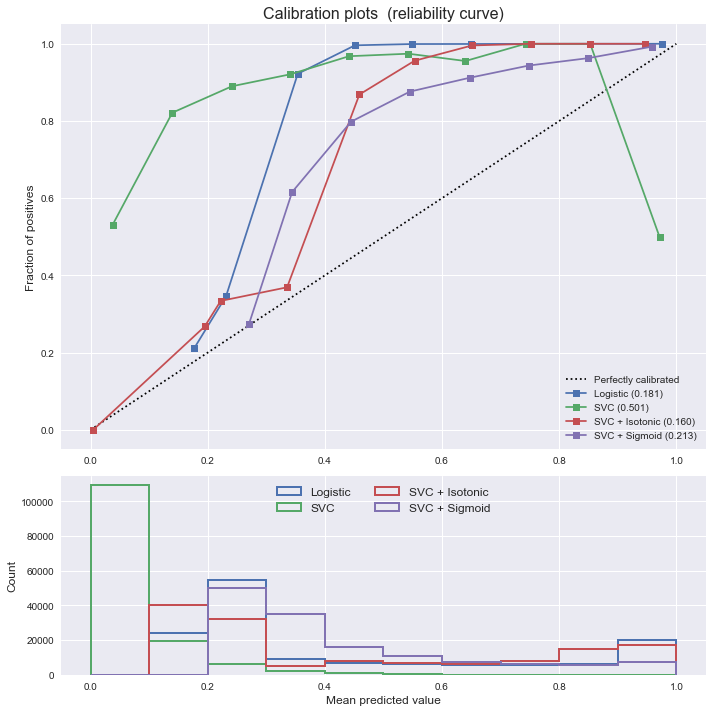

In [9]:
# Probability Calibration Curves
# copied from http://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score, f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_prior, y_prior)
        y_pred = clf.predict(X_train)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_train)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_train)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_train, prob_pos, pos_label=y_train.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_train, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_train, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_train, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_train, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives", fontsize=12)
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)', fontsize=16)

    ax2.set_xlabel("Mean predicted value", fontsize=12)
    ax2.set_ylabel("Count", fontsize=12)
    ax2.legend(loc="upper center", ncol=2, fontsize=12)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(), "SVC", 2)

plt.show()